In [3]:
import random
import matplotlib.pyplot as plot

from abc import ABC
from abc import abstractmethod
from math import sqrt
from math import log10
from typing import Iterable
from itertools import repeat

In [4]:
class RandomGenerator(ABC):
    _NUM_LENGTH = 8
    _LEFT_BOUND = 10000000
    _RIGHT_BOUND = 99999999

    def __init__(self, *, seed: int = None):
        if seed is None:
            self.seed = random.randint(self._LEFT_BOUND, self._RIGHT_BOUND)
        elif not self._LEFT_BOUND <= seed <= self._RIGHT_BOUND:
            raise ValueError(f"Seed must be in [{self._LEFT_BOUND};{self._RIGHT_BOUND}].")
        else:
            self.seed = seed

    @abstractmethod
    def generate(self, *, amount: int) -> Iterable:
        pass

# Метод середины квадрата

In [5]:
class MiddleSquareRandomGenerator(RandomGenerator):
    _OFFSET = 4
    _SQUARE_LENGTH = 16

    def __init__(self, *, seed: int = None):
        super().__init__(seed=seed)

    def generate(self, *, amount: int) -> Iterable:
        for _ in repeat(None, amount):
            squared_str = str(self.seed ** 2).zfill(self._SQUARE_LENGTH)
            mid_number = int(squared_str[self._OFFSET:self._SQUARE_LENGTH - self._OFFSET])
            yield mid_number / 10 ** self._NUM_LENGTH
            self.seed = mid_number

 # Мультипликативный конгруэнтный метод

In [6]:
class MultiplicativeCongruentRandomGenerator(RandomGenerator):
    def __init__(self, *, seed: int = None, m: int, k: int):
        super().__init__(seed=seed)
        self.m = m
        self.k = k

    def generate(self, *, amount: int) -> Iterable:
        for _ in repeat(None, amount):
            self.seed = self.k * self.seed % self.m
            yield round(self.seed / self.m, self._NUM_LENGTH)

In [7]:
expectation = lambda seq: sum(seq) / len(seq)
dispersion = lambda seq, exp: sum([e ** 2 - exp ** 2 for e in seq]) / len(seq)

In [8]:
class Tests:
    _TARGET_EXPECTATION = 0.5
    _TARGET_DISPERSION = 1 / 12
    _SELECTION_SIZE = [1000, 3000, 5000, 8000, 10000]

    selections = {}

    def __init__(self, *, generator: RandomGenerator):
        self.generator = generator
        for selection in self._SELECTION_SIZE:
            self.selections[selection] = [e for e in self.generator.generate(amount=selection)]

    def uniform_test(self):
        self._test_expectation()
        self._test_dispersion()
        for (size, sequence) in zip(self.selections.keys(), self.selections.values()):
            plot.ylabel("Frequency")
            plot.xlabel("Z")
            self._create_histogram(seq=sequence, size=size, plt=plot)
            plot.show()

    def independence_test(self, *, shift):
        plot.title("Correlation")
        plot.ylabel("Value")
        plot.xlabel("Amount")
        plot.axline((0, 0), (self._SELECTION_SIZE[-1], 0), linestyle="-")
        self._fill_plot(plot, lambda x: self._find_correlation(seq=x, shift=shift))
        plot.show()

    def _test_expectation(self):
        plot.title("Expectation")
        plot.ylabel("Value")
        plot.xlabel("Amount")
        plot.axline((0, self._TARGET_EXPECTATION), (self._SELECTION_SIZE[-1], self._TARGET_EXPECTATION), linestyle="-")
        self._fill_plot(plot, lambda x: expectation(x))
        plot.show()

    def _test_dispersion(self):
        plot.title("Dispersion")
        plot.ylabel("Value")
        plot.xlabel("Amount")
        plot.ylim(0.07, 0.09)
        plot.axline((0, self._TARGET_DISPERSION), (self._SELECTION_SIZE[-1], self._TARGET_DISPERSION), linestyle="-")
        self._fill_plot(plot, lambda x: dispersion(x, expectation(x)))
        plot.show()

    def _find_correlation(self, *, seq: Iterable, shift: int) -> float:
        x = seq[:-shift]
        y = seq[shift:]
        xy = [e1 * e2 for (e1, e2) in zip(x, y)]
        x_exp = expectation(x)
        y_exp = expectation(y)
        xy_exp = expectation(xy)
        x_disp = dispersion(seq=x, exp=x_exp)
        y_disp = dispersion(seq=y, exp=y_exp)
        return (xy_exp - x_exp * y_exp) / sqrt(x_disp * y_disp)

    def _fill_plot(self, plt, func, *args):
        for (size, sequence) in zip(self.selections.keys(), self.selections.values()):
            val = func(sequence, *args)
            plt.plot(size, val, '.')

    def _create_histogram(self, *, seq, size, plt):
        sections = int(sqrt(size) + 1 if size <= 100 else 3 * log10(size))
        delta = 1 / sections
        left = 0
        for _ in repeat(None, sections):
            right = left + delta
            cnt = self._count_entry(seq=seq, left=left, right=right)
            h = cnt / size
            plt.bar(left, h, width=delta, align="edge")
            left = right

    def _count_entry(self, *, seq, left, right):
        cnt = 0
        for e in seq:
            if left <= e < right:
                cnt += 1
        return cnt

In [9]:
mid_gen = MiddleSquareRandomGenerator(seed=12345678)
mid_square_tests = Tests(generator=mid_gen)
coeg_gen = MultiplicativeCongruentRandomGenerator(seed=12345678, m=4294967296, k=479001599)
coeg_tests = Tests(generator=coeg_gen)

# Тестирование равномерности метода середины квадрата

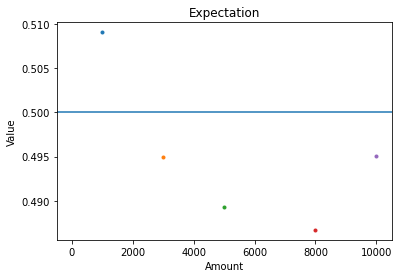

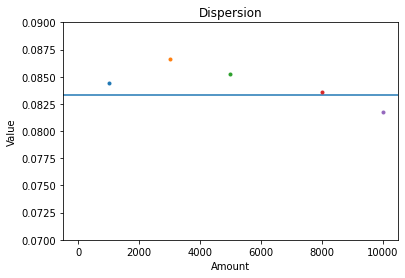

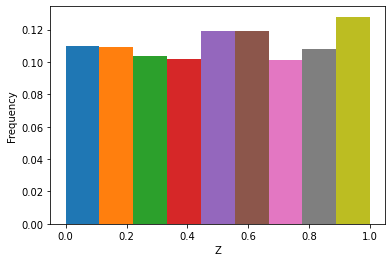

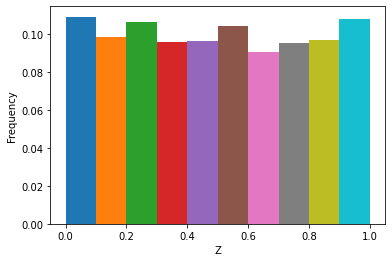

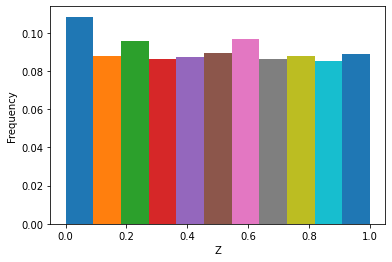

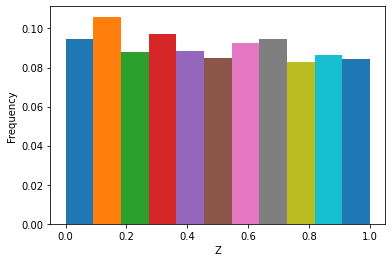

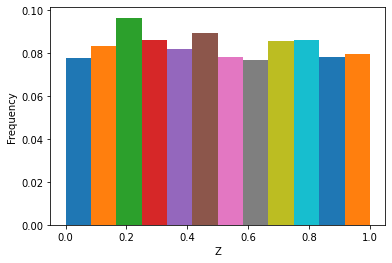

In [10]:
mid_square_tests.uniform_test()

# Тестирование независимости метода середины квадрата


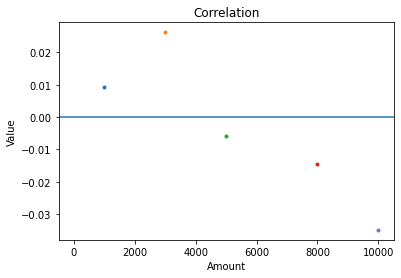

In [11]:
mid_square_tests.independence_test(shift=50)

# Тестирование равномерности мултипликативно конгруэнтного метода

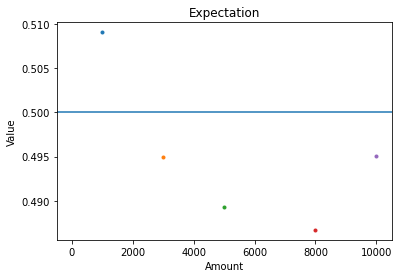

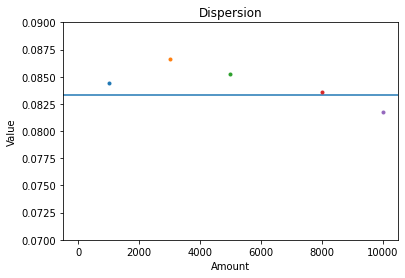

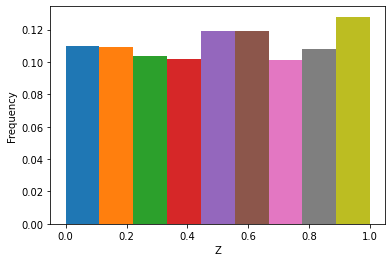

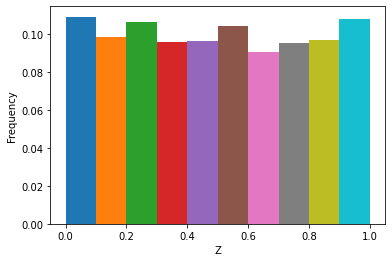

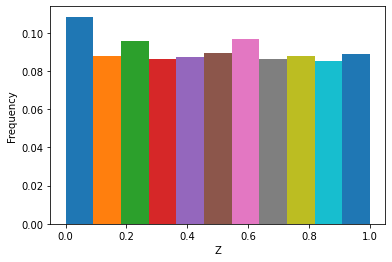

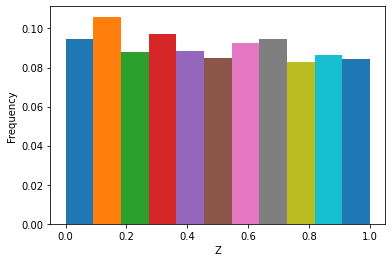

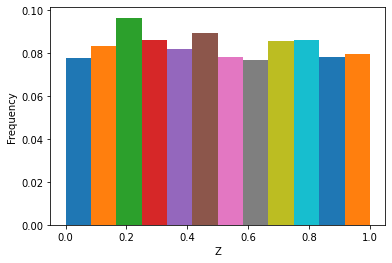

In [12]:
coeg_tests.uniform_test()

# Тестирование независимости мултипликативно конгруэнтного метода

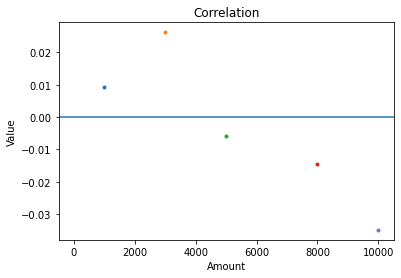

In [13]:
coeg_tests.independence_test(shift=50)